In [1]:
from apqc.sample_data import get_2d_toy_data

D = 2
samples = 2000
batch_manual = 1000
scan_length = 3

X, y = get_2d_toy_data("original_paper_toy_data_1", n_samples=samples, noise=0.15)

In [2]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_gen = scaler.fit_transform(X)

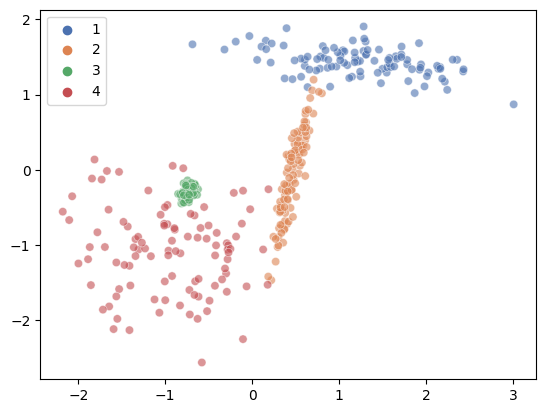

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(x=x_gen[:, 0], y=x_gen[:, 1], alpha=0.6, hue=y.flatten(), palette="deep")
plt.show()

In [4]:
from apqc.pqc import PQC

pqc = PQC(data_gen=x_gen, float_type=32, batch=batch_manual, force_cpu=True)

result_dict = {
    "sigmas": [],
    "clusters_sgd": [],
    "clusters_proba": [],
    "likelihood": []
}

2023-09-26 16:44:12.343158: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-26 16:44:13.237573: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-26 16:44:13.244554: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-26 16:44:17.279283: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Batch is greater than the sample size, therefore it is reduced to sample size.


In [5]:
import numpy as np
from apqc.density_estimation import DensityEstimator

d_e = DensityEstimator(data_gen=pqc.data_gen, batch=batch_manual, scale=pqc.scale)

init_log_sigmas = np.ones((d_e.data_gen.shape[0], 1)) * np.log(1)

ll = d_e.fit(preset_init=init_log_sigmas)

log_sigmas = d_e.log_sigma.value()
sigmas = np.exp(log_sigmas)

Batch is greater than the sample size, therefor it is reduced to sample size.


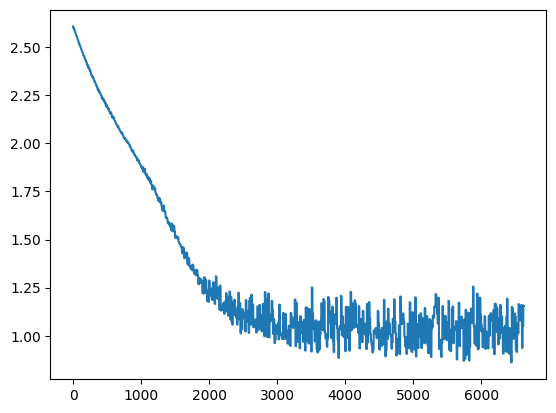

In [6]:
plt.plot(ll)
plt.show()

/tmp/ipykernel_1259498/1280857192.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('RdYlBu')


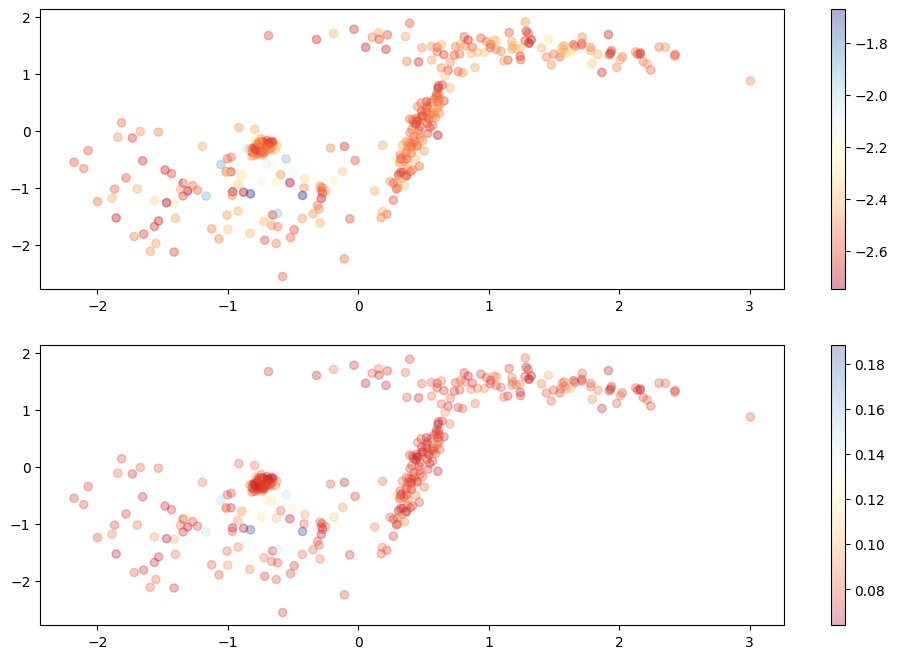

In [7]:
cm = plt.cm.get_cmap('RdYlBu')
fig, axs = plt.subplots(2, 1, figsize=(12, 8))

sc0 = axs[0].scatter(x_gen[:, 0], x_gen[:, 1], c=log_sigmas, vmin=min(log_sigmas), vmax=max(log_sigmas),
                        s=35, cmap=cm, alpha=0.4)
sc1 = axs[1].scatter(x_gen[:, 0], x_gen[:, 1], c=sigmas, vmin=min(sigmas), vmax=max(sigmas),
                        s=35, cmap=cm, alpha=0.3)
fig.colorbar(sc0, ax=axs[0])
fig.colorbar(sc1, ax=axs[1])
plt.show()

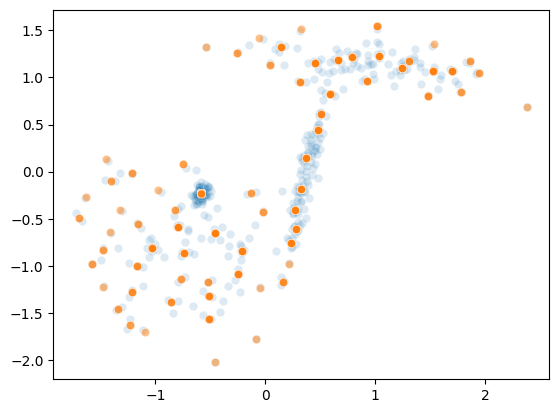

Generative data is trained in 331 steps and 6.814 s
Time to get labels from connected pairs: 0.006 s
Detected 79 clusters, having 100 samples the most populated cluster.
Reduce op runtime: 8.551 s
Computed clusters probabilities in 8.898 s
Detected 69 probability clusters.
Elapsed time for computing the full data_gen pairwise distance matrix: 0.074 s


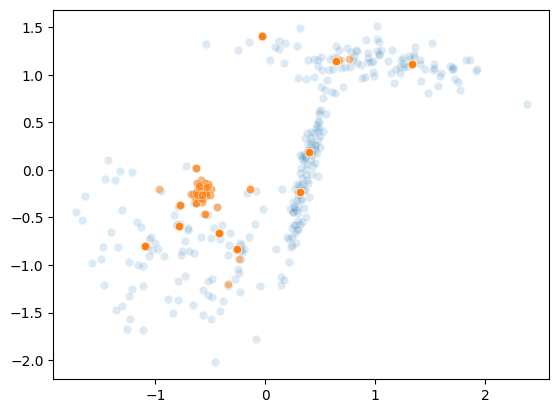

Generative data is trained in 1604 steps and 20.862 s
Time to get labels from connected pairs: 0.006 s
Detected 99 clusters, having 56 samples the most populated cluster.
Reduce op runtime: 0.001 s
Computed clusters probabilities in 0.037 s
Detected 94 probability clusters.
Elapsed time for computing the full data_gen pairwise distance matrix: 0.075 s


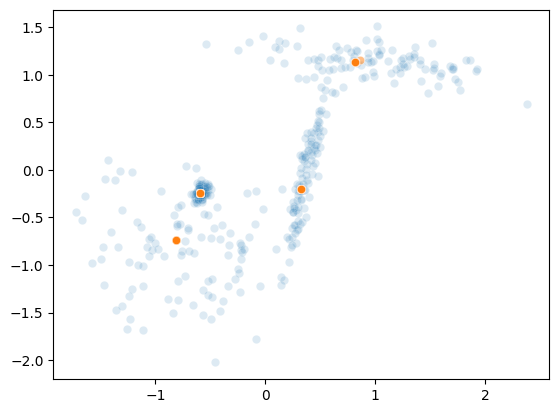

Generative data is trained in 1675 steps and 15.818 s
Time to get labels from connected pairs: 0.004 s
Detected 9 clusters, having 111 samples the most populated cluster.
Reduce op runtime: 0.001 s
Computed clusters probabilities in 0.031 s
Detected 4 probability clusters.
Elapsed time for computing the full data_gen pairwise distance matrix: 0.034 s


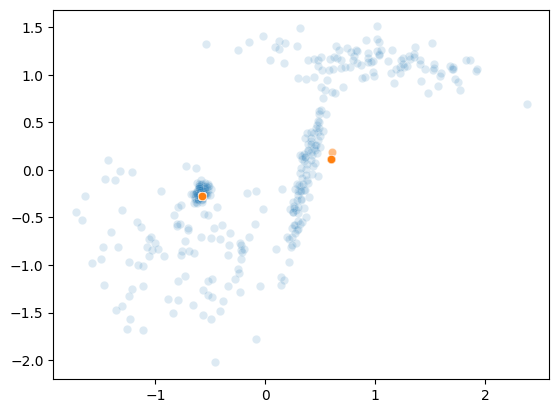

Generative data is trained in 2144 steps and 18.188 s
Time to get labels from connected pairs: 0.004 s
Detected 3 clusters, having 218 samples the most populated cluster.
Reduce op runtime: 0.001 s
Computed clusters probabilities in 0.031 s
Detected 2 probability clusters.


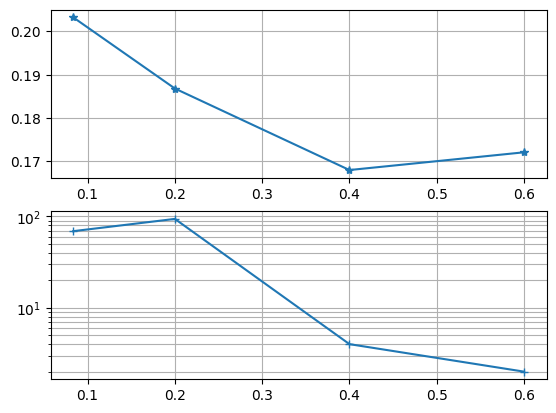

In [8]:
import pandas as pd

pqc.set_sigmas(sigma_value=sigmas)
pqc.cluster_allocation_by_sgd()
pqc.cluster_allocation_by_probability()
sgd_k = np.unique(pqc.sgd_labels).shape[0]
proba_k = np.unique(pqc.proba_labels).shape[0]
result_dict["sigmas"].append(np.mean(sigmas))
result_dict["clusters_sgd"].append(sgd_k)
result_dict["clusters_proba"].append(proba_k)
result_dict["likelihood"].append(pqc.ll)

for i, sigma_i in enumerate(np.linspace(0.2, 0.6, scan_length)):
    pqc.set_sigmas(knn_ratio=sigma_i)
    pqc.cluster_allocation_by_sgd()
    pqc.cluster_allocation_by_probability()
    sgd_k = np.unique(pqc.sgd_labels).shape[0]
    proba_k = np.unique(pqc.proba_labels).shape[0]
    result_dict["sigmas"].append(sigma_i)
    result_dict["clusters_sgd"].append(sgd_k)
    result_dict["clusters_proba"].append(proba_k)
    result_dict["likelihood"].append(pqc.ll)

results = pd.DataFrame(result_dict)

plt.subplot(2, 1, 1)
plt.plot(results["sigmas"], results["likelihood"], "-*")
plt.grid(which="both")
plt.subplot(2, 1, 2)
plt.semilogy(results["sigmas"], results["clusters_proba"], "-+")
plt.grid(which="both")
plt.show()

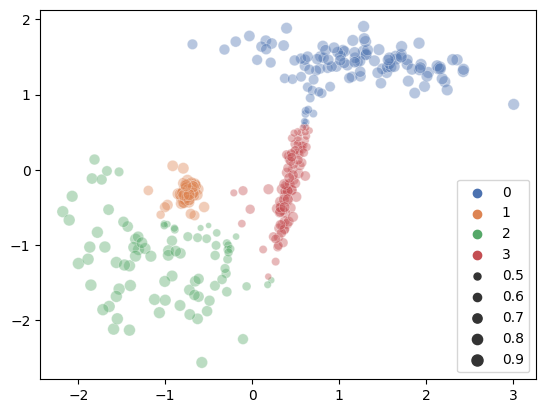

In [9]:
best_solution_key = sorted([(k, v["loglikelihood"]) for k, v in pqc.basic_results.items()], key=lambda x: x[1])[0][0]
best_proba_labels = pqc.basic_results[best_solution_key]["proba_labels"]
proba_x_k = pqc.basic_results[best_solution_key]["proba_winner"]

sns.scatterplot(x=x_gen[:, 0], y=x_gen[:, 1], alpha=0.4, hue=best_proba_labels, size=proba_x_k, palette="deep")
plt.show()

Elapsed time for computing the full data_gen pairwise distance matrix: 0.071 s


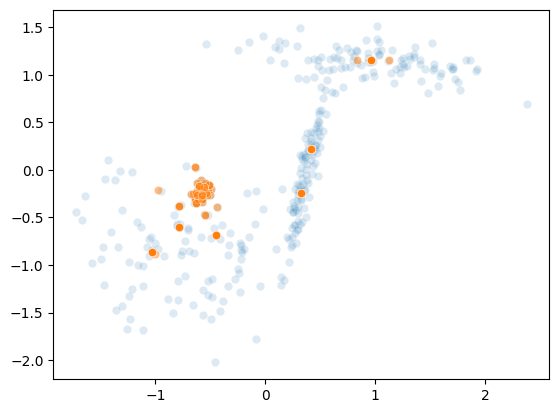

Generative data is trained in 1548 steps and 15.77 s
Time to get labels from connected pairs: 0.006 s
Detected 82 clusters, having 97 samples the most populated cluster.
Reduce op runtime: 0.002 s
Computed clusters probabilities in 0.032 s
Detected 69 probability clusters.
Potential path runtime with 69 clusters: 12.4747 s
Reduce op runtime: 5.691 s
Reduce op runtime: 0.001 s
Reduce op runtime: 0.001 s
Reduce op runtime: 0.001 s
Reduce op runtime: 0.001 s
Reduce op runtime: 0.001 s
Reduce op runtime: 0.001 s
Reduce op runtime: 0.001 s
Reduce op runtime: 0.001 s
Reduce op runtime: 0.001 s
Reduce op runtime: 0.001 s
Reduce op runtime: 0.002 s
Reduce op runtime: 0.001 s
Reduce op runtime: 0.001 s
Reduce op runtime: 0.002 s
Reduce op runtime: 0.001 s
Reduce op runtime: 0.001 s
Reduce op runtime: 0.001 s
Reduce op runtime: 0.001 s
Reduce op runtime: 0.001 s
Reduce op runtime: 0.001 s
Reduce op runtime: 0.001 s
Reduce op runtime: 0.001 s
Reduce op runtime: 0.001 s
Reduce op runtime: 0.001 s


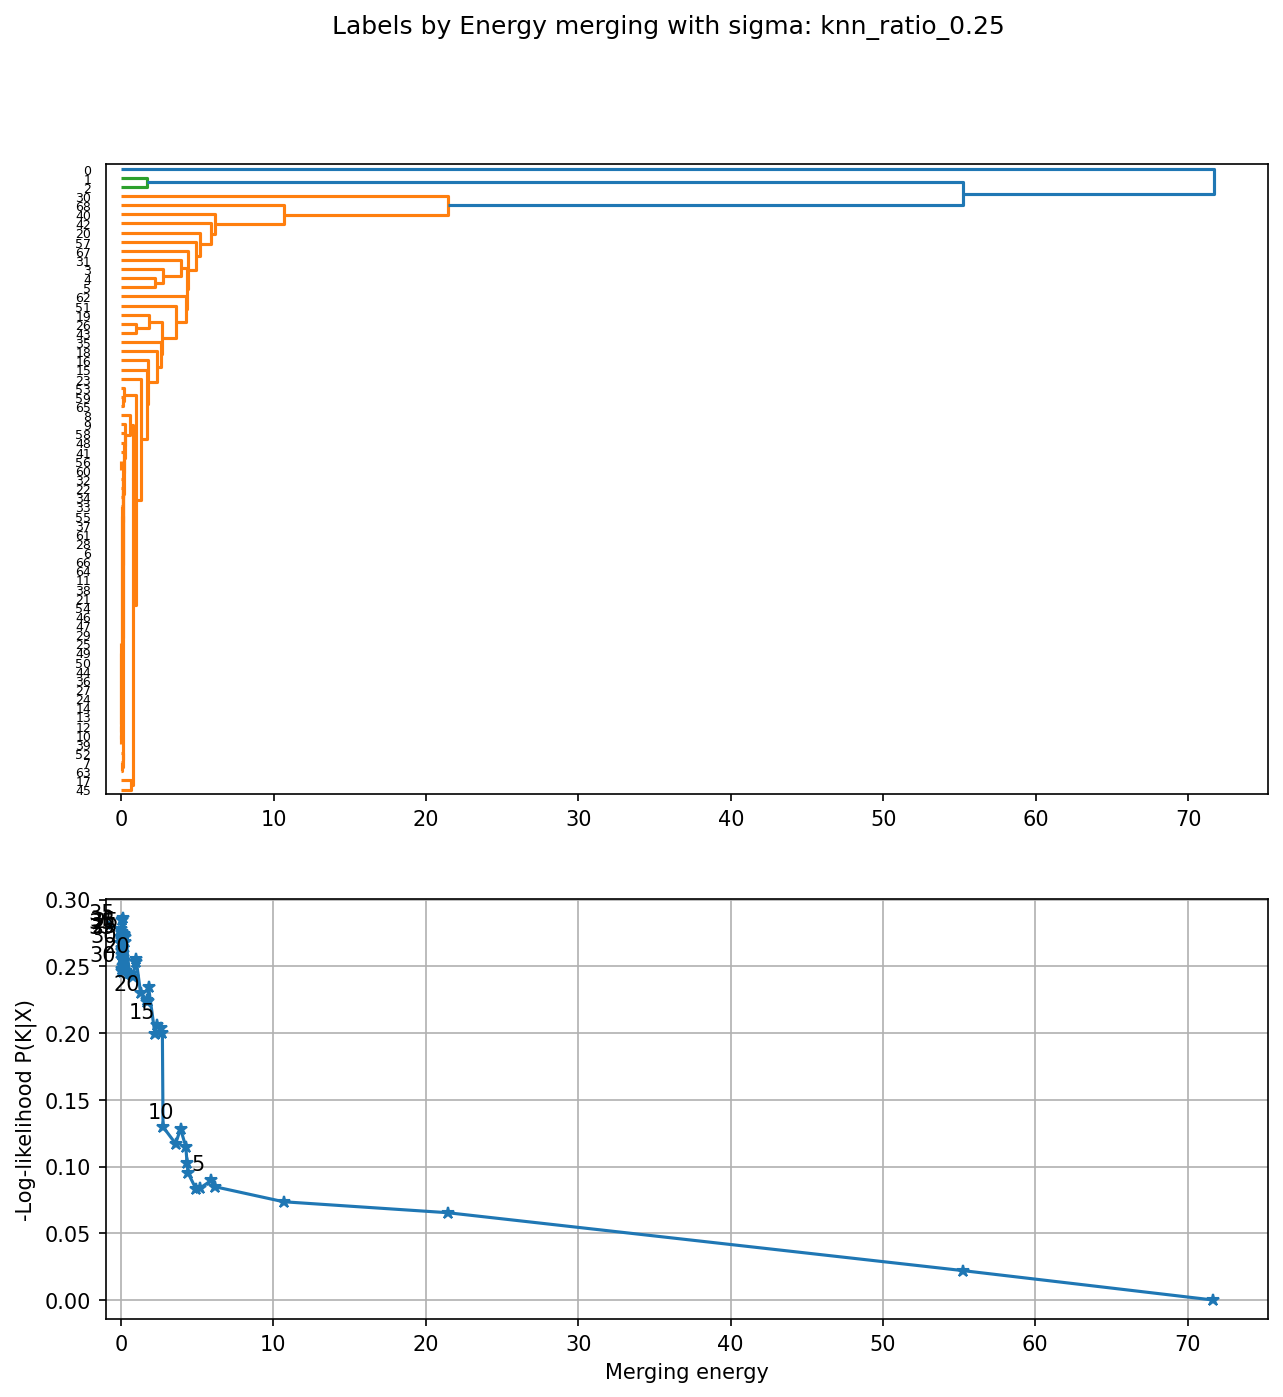

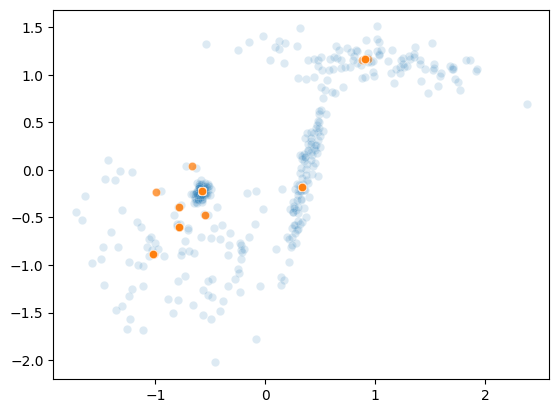

Generative data is trained in 1557 steps and 13.466 s
Time to get labels from connected pairs: 0.004 s
Detected 20 clusters, having 100 samples the most populated cluster.
Reduce op runtime: 0.001 s
Computed clusters probabilities in 0.025 s
Detected 9 probability clusters.
Potential path runtime with 9 clusters: 0.1802 s
Reduce op runtime: 0.001 s
Reduce op runtime: 0.001 s
Reduce op runtime: 0.001 s
Reduce op runtime: 0.001 s
Reduce op runtime: 0.001 s
Reduce op runtime: 0.001 s
Reduce op runtime: 0.001 s
Reduce op runtime: 0.001 s
Reduce op runtime: 0.001 s


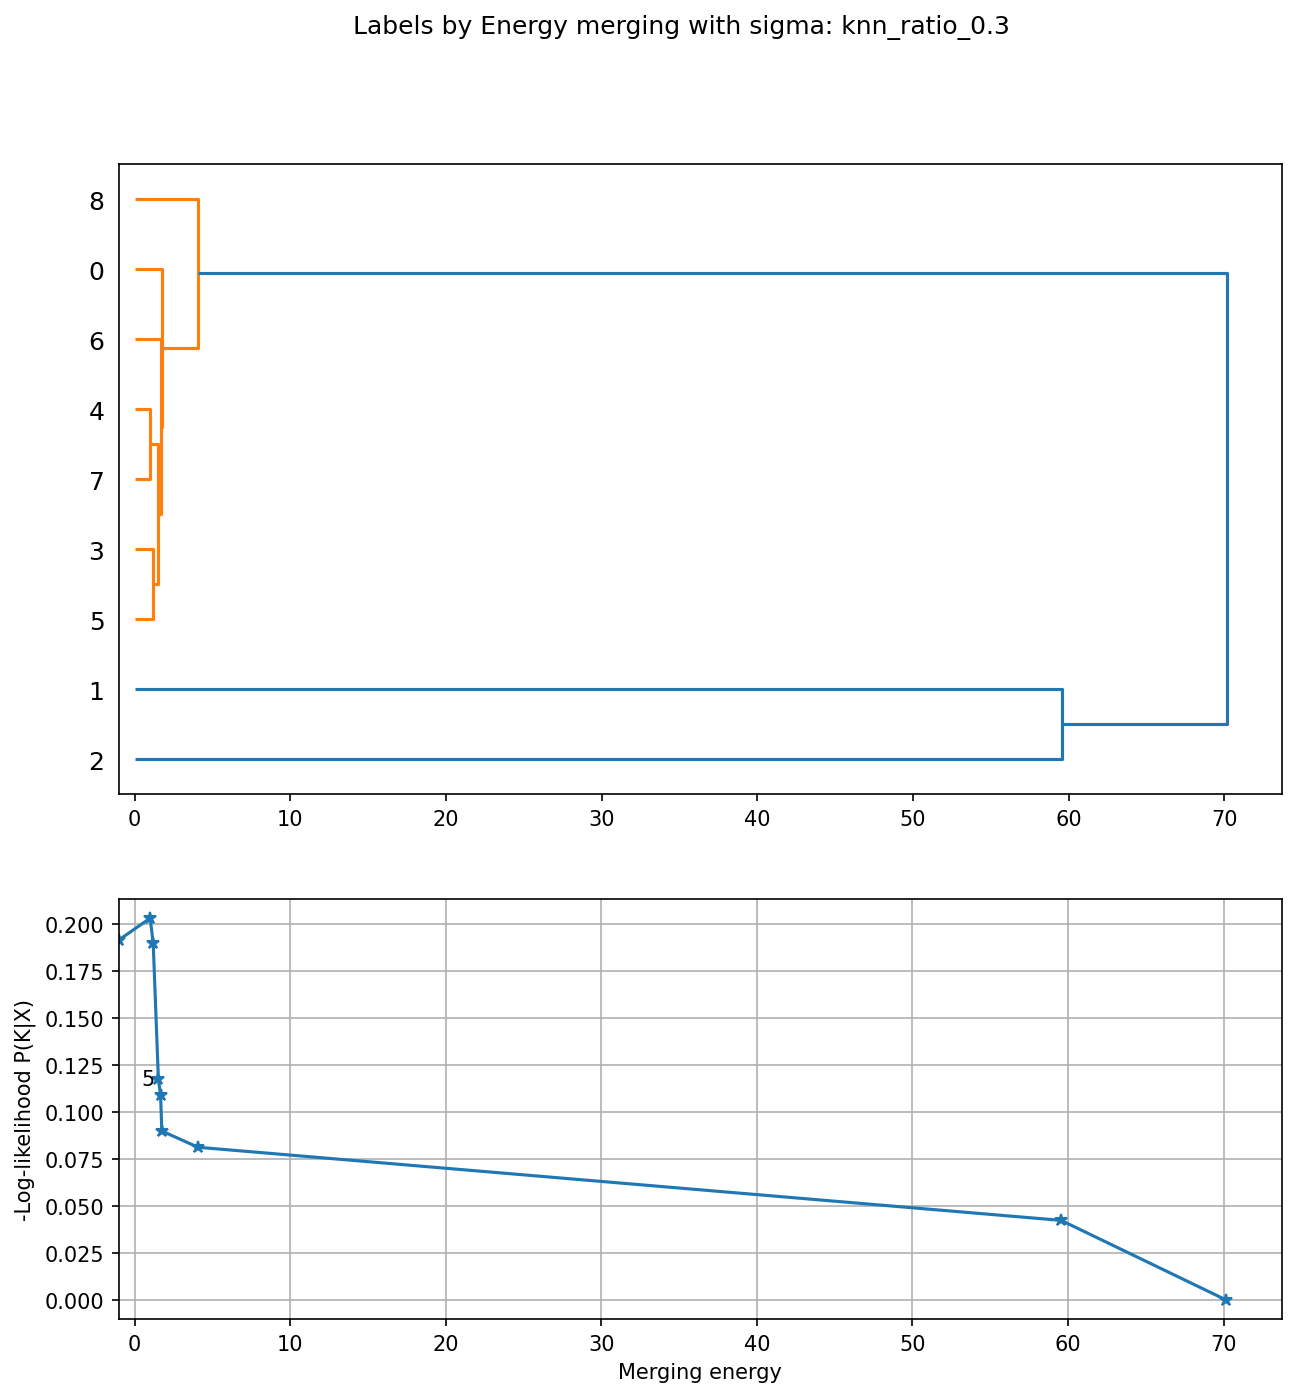

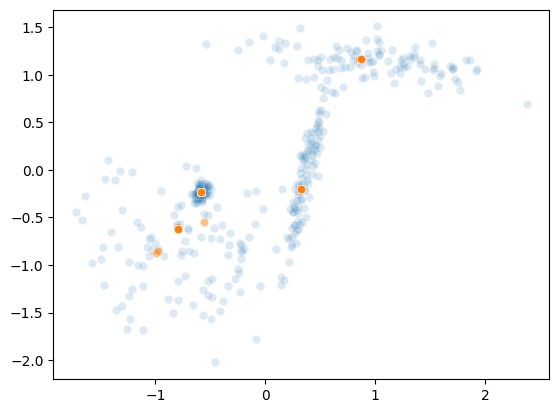

Generative data is trained in 1937 steps and 15.446 s
Time to get labels from connected pairs: 0.004 s
Detected 12 clusters, having 108 samples the most populated cluster.
Reduce op runtime: 0.001 s
Computed clusters probabilities in 0.033 s
Detected 4 probability clusters.
Potential path runtime with 4 clusters: 0.0323 s
Reduce op runtime: 0.001 s
Reduce op runtime: 0.001 s
Reduce op runtime: 0.001 s
Reduce op runtime: 0.001 s


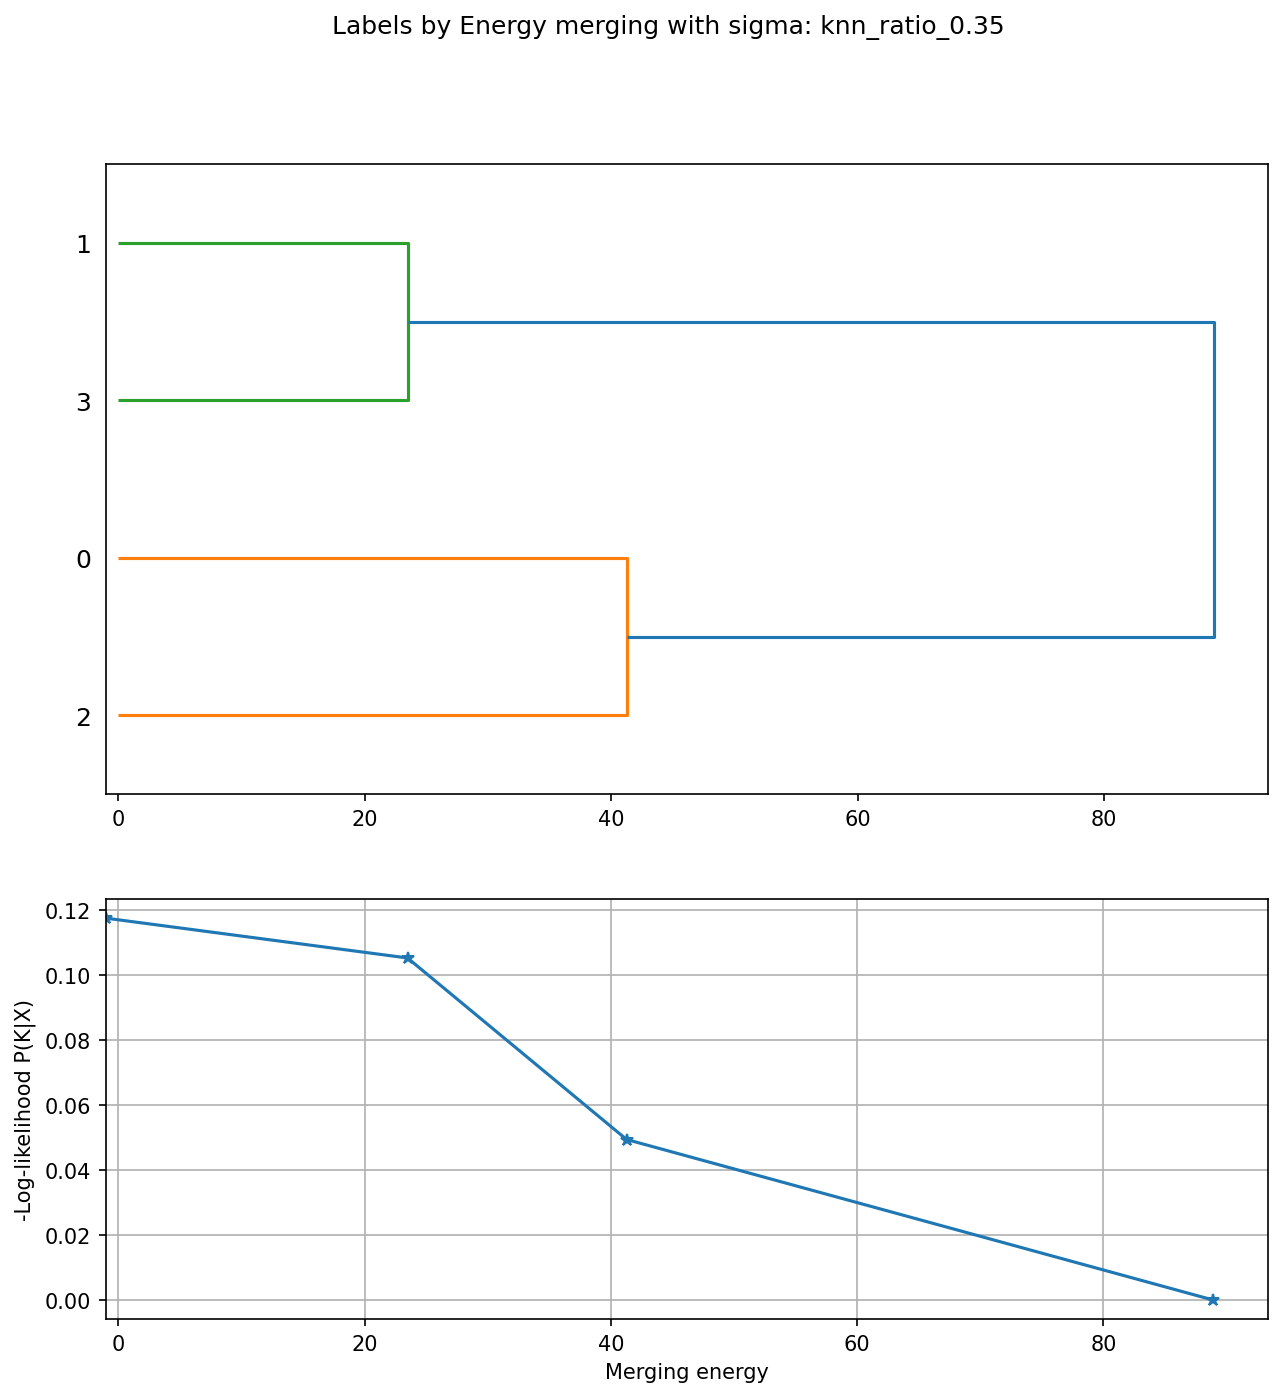

Scanning time: 75.556 s


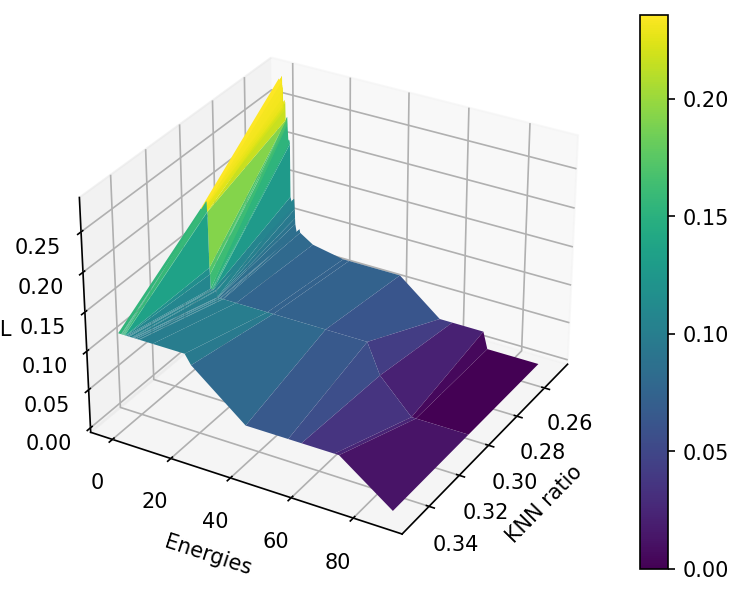

End of function!


In [10]:
knn_ratios = np.linspace(0.25, 0.35, 3)
pqc.scan_multiple_sigmas(knn_ratios=knn_ratios)